In [ ]:
## Fiber tree animation of a CNN layer

In [4]:
import pkgutil

if 'fibertree' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python3 -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet
  !python3 -m pip  install  git+https://github.com/Fibertree-Project/fibertree --quiet

from fibertree_bootstrap import *

fibertree_bootstrap(style="tree", animation="movie")

# CNN parameters
input_size = 6
kernel_size = 3
stride = 1

# Input
input_vals = [[y * input_size + x + 1 for x in range(input_size)] for y in range(input_size)]
input_tensor = Tensor.fromUncompressed(name="Input", rank_ids=["Y", "X"], root=input_vals, color="blue")

# Kernel
kernel_vals = [[1 for _ in range(kernel_size)] for _ in range(kernel_size)]
kernel_tensor = Tensor.fromUncompressed(name="Kernel", rank_ids=["dY", "dX"], root=kernel_vals, color="green")

# Output
output_tensor = Tensor(name="Output", rank_ids=["Y", "X"], color="red")

# Fibertree
in_root = input_tensor.getRoot()
ker_root = kernel_tensor.getRoot()
out_root = output_tensor.getRoot()
canvas = createCanvas(input_tensor, kernel_tensor, output_tensor)
output_size = (input_size - kernel_size) // stride + 1

# CNN loop
for oy in range(output_size):
    output_row = Fiber()
    for ox in range(output_size):
        acc = 0
        for dy, ker_row in ker_root:
            for dx, k_val in ker_row:
                iy = oy * stride + dy
                ix = ox * stride + dx

                a_val = in_root[iy][ix]
                acc += k_val * a_val
                canvas.addActivity((iy, ix), (dy, dx), (oy, ox))

        output_row.append(ox, acc)
    out_root.append(oy, output_row)
displayCanvas(canvas)

Running bootstrap
The fibertree module is already installed and available to import


interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

Starting simulation
Finished simulation


Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/146 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/146 [00:00<?, ?it/s]

In [1]:
%run ./prelude.py --style=uncompressed --animation=movie

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

Matrix Multiply
Output - before


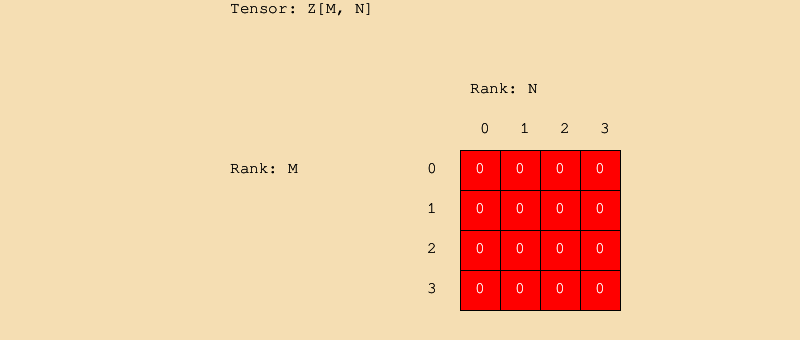

Output - after


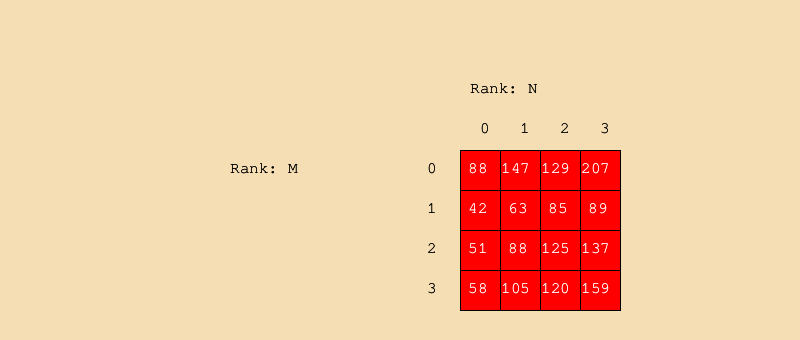

Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/66 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/66 [00:00<?, ?it/s]

In [2]:
M1 = 2
M0 = 7
K1 = 2
K0 = 7
N1 = 2
N0 = 2
M = 4
M1 = M // M0
K = 4
K1 = K // K0
N = 4
N1 = N // N0

def create_z():
    """
    Create a fully populated z tensor
    """
    z = Tensor(rank_ids=["M", "N"], default='')
    z.setName("Z")
    z.setMutable(True)

    z_m = z.getRoot()
    #
    # Hack to fill in all the entries in z
    # This allows us to pretend the tensor is dense
    #
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)

    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 0
            
    return z

print("Matrix Multiply")
a_MK_raw = []
for m in range(M):
    a_MK_raw.append([random.randint(1, 9) for i in range(K)])
                 
b_KN_raw = []
for k in range(K):
    b_KN_raw.append([random.randint(1, 9) for i in range(N)])

a_MK = Tensor.fromUncompressed(["M", "K"], a_MK_raw)
b_KN = Tensor.fromUncompressed(["K", "N"], b_KN_raw)

a_MK.setName("A_MK").setColor("blue")
b_KN.setName("B_KN").setColor("green")

z_MN = create_z()

print("Output - before")
displayTensor(z_MN)

z = z_MN.getRoot()
a = a_MK.getRoot()
b = b_KN.getRoot()

canvas = createCanvas(a_MK, b_KN, z_MN)
for m in range(M):
    a_tile = [ (m, kt) for kt in range(K)]
    for n in range(N):
        b_tile = [ (kt, n) for kt in range(K)]
        z_tile = (m, n)
        for k in range(K):
            
            z[m][n] += a[m][k] * b[k][n]
            addActivity(canvas, a_tile, b_tile, z_tile, worker="W")
            addFrame(canvas, (m,k), (k,n), (m,n))
            

print("Output - after")
displayTensor(z)

displayCanvas(canvas)
    

In [ ]:
def fiber_tree_viz(M, N, K, L, X, Y, steps=8):
    z_MN = create_out()
    
    # Function to initialize the canvas for visualization
    def create_out():
        z = Tensor(rank_ids=["M", "N"], default='')
        z.setName("Parallel Filter Executions on PEs")
        z.setMutable(True)
    
        z_m = z.getRoot()
        n_fiber = Fiber(coords=range(N), initial=1)
        m_fiber = Fiber(coords=range(M), initial=1)
    
        for m, (z_n, _) in z_m << m_fiber:
            for n, (z_ref, _) in z_n << n_fiber:
                z_ref <<= 0
    
        return z
    
    # Set the canvas for displaying the tensor
    canvas = createCanvas(z_MN)
    
    # Define the tile updates (assuming each PE gets a slice of the input matrix)
    parallel_updates = [
        [(a + K * m, b + L * n) for a in range(K) for b in range(L)] 
        for m in range(M // K) for n in range(N // L)
    ]
    
    # Visualization workers (PE grid simulation)
    workers = ["W", "X", "Y"]
    colors = ["blue", "green", "purple"]
    
    for step in range(num_steps):
        for i in range(M // K):
            for j in range(N // L):
                # Apply updates to the tensor (simulation of convolution step)
                for x, y in parallel_updates[i * (N // L) + j]:
                    z_MN[x][y] += random.randint(1, 9)  # Apply random update for simulation
                # Assign workers in a round-robin fashion
                worker_idx = (i * (N // L) + j) % len(workers)
                for update in parallel_updates[i * (N // L) + j]:
                    addActivity(canvas, update, worker=workers[worker_idx])
        addFrame(canvas)
    
    
    # Display the final output after all steps
    displayCanvas(canvas)

**Small scale version of 8x21 grid for 7x7**

In [25]:
import random
import math
from more_itertools import chunked

M, N = 15, 15
K, L = 7, 7
REPEATS = 1

# PE Grid size
PE_X, PE_Y = 3, 7

def create_out():
    z = Tensor(rank_ids=["M", "N"], default='')
    z.setName(f"{PE_Y}x{PE_X} Row-Stationary CNN")
    z.setMutable(True)

    z_m = z.getRoot()
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)

    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 0
    return z

z_MN = create_out()
canvas = createCanvas(z_MN)

# Tiling
tile_M = math.ceil(M / K)
tile_N = math.ceil(N / L)

tile_jobs = []

for m in range(tile_M):
    for n in range(tile_N):
        tile_coords = []
        for a in range(K):
            for b in range(L):
                x = m * K + a
                y = n * L + b
                if x < M and y < N:
                    tile_coords.append((a, b, x, y))
        tile_jobs.append(tile_coords)
tile_jobs *= REPEATS
total_cycles = 0

for tile in tile_jobs:
    for k_row_group in range(0, K, PE_Y):
        for pe_row in range(PE_Y):
            k_row = k_row_group + pe_row
            if k_row >= K:
                continue
            for a, b, x, y in tile:
                if a == k_row:
                    pe = (pe_row, b)  # (PE row, PE col = kernel col)
                    worker_id = f"PE{pe}"
                    z_MN[x][y] += random.randint(1, 9)
                    addActivity(canvas, (x, y), worker=worker_id)
        addFrame(canvas)
        total_cycles += 1

displayCanvas(canvas)
print(f"Total cycles (animation frames): {total_cycles}")


Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/11 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/11 [00:00<?, ?it/s]

Total cycles (animation frames): 9


**Small scale version of 21x8 grid for 7x7**

In [26]:
import random
import math
from more_itertools import chunked

M, N = 15, 15
K, L = 7, 7
REPEATS = 1

# PE Grid size
PE_X, PE_Y = 7, 3

def create_out():
    z = Tensor(rank_ids=["M", "N"], default='')
    z.setName(f"{PE_Y}x{PE_X} Row-Stationary CNN")
    z.setMutable(True)

    z_m = z.getRoot()
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)

    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 0
    return z

z_MN = create_out()
canvas = createCanvas(z_MN)

# Tiling
tile_M = math.ceil(M / K)
tile_N = math.ceil(N / L)

tile_jobs = []

for m in range(tile_M):
    for n in range(tile_N):
        tile_coords = []
        for a in range(K):
            for b in range(L):
                x = m * K + a
                y = n * L + b
                if x < M and y < N:
                    tile_coords.append((a, b, x, y))
        tile_jobs.append(tile_coords)
tile_jobs *= REPEATS
total_cycles = 0

for tile in tile_jobs:
    for k_row_group in range(0, K, PE_Y):
        for pe_row in range(PE_Y):
            k_row = k_row_group + pe_row
            if k_row >= K:
                continue
            for a, b, x, y in tile:
                if a == k_row:
                    pe = (pe_row, b)  # (PE row, PE col = kernel col)
                    worker_id = f"PE{pe}"
                    z_MN[x][y] += random.randint(1, 9)
                    addActivity(canvas, (x, y), worker=worker_id)
        addFrame(canvas)
        total_cycles += 1

displayCanvas(canvas)
print(f"Total cycles (animation frames): {total_cycles}")


Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/29 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/29 [00:00<?, ?it/s]

Total cycles (animation frames): 27
